# University of Aberdeen

## Applied AI (CS5079)

### Assessment 1 Task 1 - Reinforcement Learning from the Screen Frames

---


## Imports

In [ ]:
# OpenAI has preprocessing modules in their baselines repository 
# such as FrameStack, NoopResetEnv, episode_life, etc.
# To import those we first need to install the OpenAI baseline package
# via running this code cell.
!pip install git+https://github.com/openai/baselines.git

In [2]:
# Seed value used for achieving reproducibility
SEED_VALUE = 1337

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
# For handling files
import os
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISM'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED_VALUE)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(SEED_VALUE)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(SEED_VALUE)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(SEED_VALUE)


# https://github.com/openai/baselines
from baselines.common.atari_wrappers import make_atari, wrap_deepmind, NoopResetEnv, FrameStack

# For plotting graphs
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# OpenAI Gym
import gym

# The frame stack size
FRAME_STACK_SIZE = 5

# Make the Atari game and its environment assign it to
# a variable for later use (RL of the DDQN agent).
env = gym.make("Asterix-v0")

# Preprocess the environment (downsampling to 84x84 and
# scaling the input image pixels of the game)
env = wrap_deepmind(env, frame_stack=False, scale=True, clip_rewards=False, episode_life=False)

# Stack the input image frames by FRAME_STACK_SIZE
env = FrameStack(env, FRAME_STACK_SIZE)

# Seed the Atari game environment
env.seed(SEED_VALUE)

[1337, 17452119]

## Task 1.1

In [ ]:
class RandomAgent():
    """
    RandomAgent class used for creating agent instances, which only explore the
    game environment via random actions (without learning anything about it).
    Args:
        env (AtariEnv): Atari game environment
    """
    def __init__(self, env):
        """Initialise a list of possible agent actions for the environment. 
        These are taken from the environment's action space.
        """
        self.action_space = env.action_space.n
        
    def get_action(self, observation):
        """Return a random actions
        """
        return random.choice(range(self.action_space))

# Total agent reward
total_reward = 0

# Instantiate a RandomAgent object
random_agent = RandomAgent(env)

# Number of episodes to train the agent
NUM_OF_EPISODES = 1
 
# Loop over the number of episodes and 
for steps in range(NUM_OF_EPISODES):
    # Reset the game environment
    current_obs = env.reset()
    
    # Take actions and explore the environment 
    # while the agent still has lives left (done=False)
    done = False
    while not done:
        action = random_agent.get_action(current_obs)
        next_obs, reward, done, info = env.step(action)
        
        # Increment the total reward of the random agent
        total_reward += reward
        
        env.render()
env.close()
print("Average reward: {}".format(total_reward/NUM_OF_EPISODES))

In [4]:
# Print the observation and action spaces, and the Atari 
# game action space and their names (meanings)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print("Possible actions:", env.unwrapped.get_action_meanings())
# print('Info dictionary:', env.step(action)[3])
# print('Reward:', env.step(action)[1])

Observation space: Box(84, 84, 5)
Action space: Discrete(9)
Possible actions: ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


To display this, a simple agent that performs random actions for one episode is implemented.

- **Observations**: `env.observation_space` shows that the obseravtion space is an RGB image of which is an array of shape $(210, 160, 3)$, indicating a height of $210$ pixels, a width of $160$ pixels and $3$ channels.


- **Action Space**: `env.action_space` shows us that the action space is *discrete* with $9$ possible actions that are printed out for better understanding using `env.unwrapped.get_action_meanings()`. Each action is performed repeatedly for a duration of $k$ frames, where $k$ is sampled from the set ${2,3,4}$ uniformly. The discrete space allows for a fixed range of non-negative numbers, where low (`env.observation_space.low`) will be a grid filled with zeros $(0\times0\times0)$ and high (`env.observation_space.high`) will be a grid filled with $250\times250\times250$.


- **Reward**: $0$ but is accumulated as an episode is played and the player collects cauldrons and items giving him points. 


- **Environment's info dictionary**: The info dictionary contains `ale.lives()` which refers to the number of lives left. In our case, the player has only $3$ lives that decrease as he collides with the lyres.


- **Episode**: An episode is concluded when the player loses a life. When a game is played and `done=True`, this indicates that the game is finished and the player has lost all lives. 




## Task 1.2

Please refer to the report for this task.

## Task 1.3

We are using a special wrapper for the purpose of environment preprocessing. 

This reshapes the image to .... and the agent will receive a grayscale observation as we have converted the observarions to grayscale. We also scale all observations to `[0,1]`.

Another common preprocessing step is the introductioon of frame skipping (Naddaf, 2010 at https://era.library.ualberta.ca/items/a661eb66-f2e0-4ed3-b501-b6cbcd1fdd9d), which is what restricts the agent's decision points by repeating some selected action for $k$ consequitve frames, making the RL problem simpler and speeding up execution. 

This notebook follows an approach where the agent is designed with a richer observation space by combining past frames with most recent ones as known as frame stacking (Mnih et al., 2015 https://www.nature.com/articles/nature14236). We use $5$ frames, but the algorithm might also be robust with different values such as 3 or 4. This research experimented with all 3 options and concluded that the use of 5 images in a stack is the most beneficial approach with regards to total reward. Due to this reduction in partial observability, the agent can detect the direction of motion of in-game objects.




(84, 84, 5)


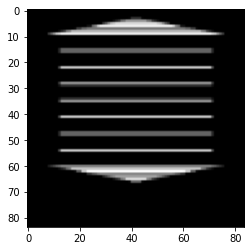

In [5]:
# Print the game image shape and plot a sample 
# image for illustration purposes
obs = env.reset()
print(env.observation_space.shape)
plt.imshow(obs[:,:,0], cmap='gray')
plt.show()

Please refer to the report for a more indepth explanation.

## Task 1.4

read this to check architecture and fig

https://www.nature.com/articles/nature14236

ARCHITECTURE
TODO:

The first hidden layer convolves 32 filters of 8 × 8 with stride 4 with the input image and applies a rectifier nonlinearity 31,32. The second hidden layer convolves 64 filters of 4 × 4 with stride 2, again followed by a rectifier nonlinearity. This is followed by a third convolutional layer that convolves 64 filters of 3 × 3 with stride 1 followed by a rectifier. The final two hidden layers are fully-connected and consist of 512 and 256 rectifier units respectively. The output layer is a fully-connected linear layer with a single output for each valid action. The number of valid actions varied between 4 and 18 on the games we considered.

In [6]:
# Import the garbage collector package
import gc

def reset_random_seeds():
    """Reset the random number generator seed to achieve full reproducibility 
    even when running the script on GPU
    """
    
    # Set the environment determinism to guarantee
    # reproducibility of the results
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISM'] = '1'
    os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
    tf.random.set_seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    random.seed(SEED_VALUE)
    
    # Perform garbage collection
    gc.collect()
    print("Random number generator seed reset!")  # optional

### Defining global variable and importing packages for training the models

In [7]:
# Import the Keras layer used for building our DDQN models
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,\
MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeUniform

# Get the input shape for the DDQN models (game environment observation space)
INPUT_SHAPE = env.observation_space.shape

# Get the output shape for the DDQN models
NUM_ACTIONS = env.action_space.n

# Set the batch size
BATCH_SIZE = 32

# Set the DDQN agent memory size.
# We use a relatively small value due to assessment time constraints
# and also to provide easier reproducibility. ===================================
MEMORY_SIZE = 25000

# Define the exploration steps of the DDQN agent.
# We do not train the model during these first steps.
EXPLORATION_STEPS = 20000

# Define the learning rate to be used for the model
# gradient descent optimisation method (Adam as opposed to RMSprop) WHY ADAM??===============================
LEARNING_RATE = 0.00025

In [8]:
class SumTree:
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an optimisation experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/rlcode/per
    Args:
        capacity (int): size of the sum tree
    """
    # The data pointer class variable
    write = 0

    def __init__(self, capacity):
        """Initialize the tree with all nodes and data with values set to 0.
        """
        # Number of leaf nodes (final nodes) that contains experiences
        self.capacity = capacity
        
        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema above
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)
        
        # Store the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)

    def _propagate(self, idx, change):
        """Recursively propagate a given child node change through the sum tree.
        """
        
        # Get the parent node index
        parent = (idx - 1) // 2
        
        # Apply the child node change to the parent node
        self.tree[parent] += change
        
        # Do this until the root node is reached
        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        """Return a leaf node (priority) index for the current experience (observation)
        """
        
        # Get the left and right child node indexes
        # for the current sample
        left = 2 * idx + 1
        right = left + 1
        
        # Return the index itself if the 
        # left child index is greater than the 
        # capacity of the sum tree
        if left >= len(self.tree):
            return idx
        
        # Start recursion
        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        """Return the root node (total sum of the experience priority values).
        """
        return self.tree[0]

    def add(self, p, data):
        """Add the experience and its priority score (as a leaf) to the sum tree.
        """
        # Get the tree index for the experience (observation)
        idx = self.write + self.capacity - 1
        
        # Update the sum tree data
        self.data[self.write] = data
        
        # Update the sum tree probability values
        self.update(idx, p)
        
        # Increment the data pointer
        self.write += 1
        
        # If over the capacity, go back to first index (we overwrite)
        if self.write >= self.capacity:
            self.write = 0

    def update(self, idx, p):
        """Update the leaf priority score and propagate the change through tree.
        """
        # Change = new priority score - former priority score
        change = p - self.tree[idx]
        self.tree[idx] = p
        
        # Propagate the change through tree
        self._propagate(idx, change)

    def get(self, s):
        """Return the leaf index, priority value and its associated experience (observation).
        """
        # Get the leaf index
        idx = self._retrieve(0, s)
        
        # Get the experience (observation) index
        dataIdx = idx - self.capacity + 1

        return (idx, self.tree[idx], self.data[dataIdx])
    

#-------------------- MEMORY --------------------------
class Memory:
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an optimisation experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/rlcode/per
    
    Args:
        capacity (int): size of the sum tree
    """
    # Hyperparameter to avoid assigning 0 probability to experiences
    e = 0.01
    
    # Hyperparameter to make a trade-off between random sampling and taking a
    # a high priority experience (observation)
    a = 0.6

    def __init__(self, capacity):
        """Initialise the sum tree with the given capacity.
        """
        self.tree = SumTree(capacity)

    def _getPriority(self, error):
        return (error + self.e) ** self.a

    def add(self, error, sample):
        """Store a new experience in the tree along with its corresponding priority value.
        """
        # Get the priority from the experience (observation) error
        p = self._getPriority(error)
        
        # Store the priority and the experience (observation)
        self.tree.add(p, sample) 

    def sample(self, n):
        """Sample a n-sized batch of priority index and observation pair.
        """
        # Create a list to hold the batch pairs
        batch = []
        
        # Calculate and store the priority segment
        segment = self.tree.total() / n
        
        # Populate the batch list
        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            batch.append( (idx, data) )

        return batch

    def update(self, idx, error):
        """Update the sum tree leaves (priorities).
        """
        # Get the priority from the experience (observation) error
        p = self._getPriority(error)
        
        # Update the sum tree probability values
        self.tree.update(idx, p)

In [9]:
# Import the math Python package
import math

# Minimum and maximum epsilon value constants
MAX_EPSILON = 1
MIN_EPSILON = 0.1

# Constant that determines the speed of the epsilon decay
LAMBDA = - math.log(0.01) / EXPLORATION_STEPS 

class DDQNAgent():
    """Code is adapted from an open-source MIT-licensed GitHub repository.
    It implements an DDQ Network and Agent experience replay memory technique that can
    be used for all Atari games DQNs. 
    
    Source: https://github.com/jaromiru/AI-blog
    
    Args:
        env (AtariEnv): the environment that RLNetwork and Agent are optimized on
        lr (float): learning rate of the network
    """
    steps = 0
    
    def __init__(self, env, lr=LEARNING_RATE):
        """Initialise the agent and the online and target DDQNs for the environment.
        """
        self.lr = lr
        
        self.memory = Memory(MEMORY_SIZE)
        
        # Set the initial DDQN models loss value to be +inf
        self.loss_val = np.inf
        self.action_space = NUM_ACTIONS
        
        # Disable eager execution which boosts runtime
        # Eager execution is generally used for debugging purposes
        tf.compat.v1.disable_eager_execution()
        self.discount_rate = 0.99

        # Create the two networks for predicting the actions
        
        # The first model makes the predictions for Q-values 
        # which are used to make a action.
        self.online = self.q_network()
        
        # Build a target model for the prediction of future
        # rewards. The weights of a target model get updated 
        # every 10,000 steps thus when the loss between the 
        # Q-values is calculated the target Q-value is stable.
        self.target = self.q_network()

        #The "target" DNN will take the values of the "online" DNN
        self.update_target()


    def q_network(self, filters_1=32, filters_2=64, filters_3=64):
        """Define and return the CNN model architecture.
        """
        # Ensure reproducibility of the results
        # by resetting the random seeds
        reset_random_seeds()

        # Build the model
        kernel_init = HeUniform()
        model = Sequential()
        model.add(Conv2D(filters_1, kernel_size=8, padding="same", strides=4, activation='relu', input_shape=INPUT_SHAPE, kernel_initializer=kernel_init))
        model.add(Conv2D(filters_2, kernel_size=4, padding="same", strides=2, activation='relu', kernel_initializer=kernel_init))
        model.add(Conv2D(filters_3, kernel_size=3, padding="same", strides=1, activation='relu', kernel_initializer=kernel_init))
        model.add(Flatten())
        model.add(Dense(512, activation='relu', kernel_initializer=kernel_init))
        model.add(Dense(256, activation='relu', kernel_initializer=kernel_init))
        model.add(Dense(NUM_ACTIONS, activation="linear", kernel_initializer=kernel_init))
        
        # In the Deepmind paper they use RMSProp however then Adam optimizer
        # improves training time
        model.compile(loss="huber_loss", optimizer=Adam(learning_rate=self.lr))
        return model
            
    def update_target(self):
        """Update the target network with the online network weights.
        """
        # Get the online DQN weights
        online_weights = self.online.get_weights()
        
        # Update the target DQN weights
        self.target.set_weights(online_weights)
        
    #---- CHOSSING ACTION ----
    def get_action(self, state, step):
        """Based on the Epsilon agent chooses wheter to explore or exploatate
        """
        if step <= EXPLORATION_STEPS:
            return np.random.randint(self.action_space)
        else:     
            self.steps += 1
            epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * self.steps)
            if np.random.rand() < epsilon:
                return np.random.randint(self.action_space)# random action
            else:
                q_values = self.online.predict(state.reshape(-1, *INPUT_SHAPE))
                return np.argmax(q_values) # optimal action
    
    def get_train_data(self, batch):
        """Decide on the input, desired output and error of the current state.
        """
        
        # NumPy array storing no observation space
        # used at the end of each episode (improved performance)
        no_state = np.zeros(INPUT_SHAPE)
        
        # Get the previous states from the batch observations
        prev_states = np.array([obs[1][0] for obs in batch])
        
        # Get the next states from the batch observations
        # No state if done = True
        next_states = np.array([(no_state if obs[1][4] is True else obs[1][3]) for obs in batch])
        
        # Make predictions based on the previous states
        # using the online model
        prev_q_vals = self.online.predict(prev_states)
        
        # Make predictions based on the next states
        # using the online model (used in the function for 
        # calculating the future q values of the DDQN)
        next_q_vals_double = self.online.predict(next_states)
        
        # Make predictions based on the next states
        # using the target model
        next_q_vals = self.target.predict(next_states)
        
        # Create NumPy arrays for storing the previous states and future q values,
        # and the calculated error values (used for determining state priorities)
        # respectively
        X = np.zeros((len(batch), *INPUT_SHAPE))
        Y = np.zeros((len(batch), NUM_ACTIONS))
        errors = np.zeros(len(batch))
        
        for idx in range(len(batch)):
            
            # Unpack the current batch sample
            curr_state, action, reward, next_state, done = batch[idx][1]
            
            # Get the current (previous/old) state q value
            q_val = prev_q_vals[idx]
            prev_q_val = q_val[action]
            
            # Future q value is the current q val
            # which is to be updated using the predictions of
            # both the online and the target models
            future_q_val = q_val
            
            # Update the future q value
            if done:
                future_q_val[action] = reward
            else:
                future_q_val[action] = reward + next_q_vals[idx][np.argmax(next_q_vals_double[idx])] * self.discount_rate
            
            # Populate the previous state and future q value lists 
            X[idx] = curr_state
            Y[idx] = future_q_val
            
            # Calculate the error values for each experience (observation)
            errors[idx] = abs(prev_q_val - future_q_val[action])
        
        return (X, Y, errors)
    
    def save_to_memory(self, curr_state, action, reward, next_state, done, step):
        """Update the sum tree priorities and observations (samples).
        """
        sample = (curr_state, action, reward, next_state, done)
        if step <= EXPLORATION_STEPS:
            error = abs(sample[2])  # Reward
            self.memory.add(error, sample)
        else:
            X, Y, errors = self.get_train_data([(0, sample)])
            self.memory.add(errors[0], sample)
        
    def train(self, step):
        """Train the online model and update the loss value.
        """
        
        batch = self.memory.sample(BATCH_SIZE)
        X, Y, errors = self.get_train_data(batch)
        
        # Update errors
        for i in range(len(batch)):
            idx = batch[i][0]
            self.memory.update(idx, errors[i])
        
        hist = self.online.fit(X, Y, batch_size=BATCH_SIZE, epochs=1, verbose=0, shuffle=True)
        self.loss_val = hist.history['loss'][0]
    


Please refer to the report for further information regarding the deployment and parameter adjustments of the agent.

## Task 1.5

In [10]:
import time

# Initialise the DDQN agent 
ddqn_agent = DDQNAgent(env)  

# Lists to hold the steps and their corresponding rewards respectively 
ep_steps, ep_rewards = [], []

# To hold the total episode reward of the agent
total_reward = 0

# Total number of training steps
N_STEPS = 1000000  

# Train the model after 4 actions
TRAIN_ONLINE_STEPS = 4

# Update teh target every 10,000 steps (1 epoch)
# Considered as a hyperparameter
UPDATE_TARGET_STEPS = 10000

# Start the DDQN agent game exploration and training loop
done=True
for step in range(N_STEPS):
    
    # Calculate the DDQN agent training process
    # completion as percentage
    total_perc = step * 100 / N_STEPS
    
    # Print the current step, total number of training steps, training process percentage and DDQN loss value
    print(f"\r\tAction step: {step}/{N_STEPS} ({total_perc:.2f}%)\tLoss: {ddqn_agent.loss_val:5f}", end="")
    
    # Reset the game environment once the ddqn_agent
    # is out of lives
    if done:
        
        # Calculate the average reward for the episode (for 3 lives)
        avg_reward = int(total_reward/3)
        
        # Append the total reward and episode steps
        # used later for plotting and printing
        if step:
            ep_rewards.append(total_reward)
            ep_steps.append(step)
        
        # Print the most recent average (mean) episode and total (all episodes so far) reward values 
        print(f"\tAVG reward: {avg_reward}\tTotal mean: {np.mean(ep_rewards)}")
        
        # Reset the game environment and get the initial observation
        obs = env.reset()
        
        # Conver the observation to NumPy array
        # since we need such arrays to carry out the ddqn_agent training
        state = np.array(obs)
        
        # Reset the total episode reward since
        # we start a new episode
        total_reward = 0


    # Get a exploration/exploitation action
    action = ddqn_agent.get_action(state, step)

    # Take a step in the game environment
    next_state, reward, done, info = env.step(action)
    
    # Convert to NumPy array
    next_state = np.array(next_state)
    
    # Update the sum tree priorities and observations (samples)
    ddqn_agent.save_to_memory(state, action, reward, next_state, done, step)
    
    # Skip training the DDQN agent if still exploring
    if step > EXPLORATION_STEPS:
        
        # Train the online DDQN every 4th frame
        if step % TRAIN_ONLINE_STEPS == 0:
            ddqn_agent.train(step)

        # Regularly (every 10000 steps) copy the online DDQN to the target DDQN
        if step % UPDATE_TARGET_STEPS == 0:
            ddqn_agent.update_target()
    
    # Render the game environment
    env.render()
    
    # Increment the total reward by the current reward
    total_reward += reward
    state = next_state

# Close the game environment 
env.close()

Random number generator seed reset!
Random number generator seed reset!
	Action step: 0/1000000 (0.00%)	Loss:   inf	AVG reward: 0	Total mean: nan


c:\program files\python38\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\program files\python38\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


	Action step: 329/1000000 (0.03%)	Loss:   inf	AVG reward: 100	Total mean: 300.0
	Action step: 705/1000000 (0.07%)	Loss:   inf	AVG reward: 83	Total mean: 275.0
	Action step: 1301/1000000 (0.13%)	Loss:   inf	AVG reward: 250	Total mean: 433.3333333333333
	Action step: 1801/1000000 (0.18%)	Loss:   inf	AVG reward: 150	Total mean: 437.5
	Action step: 2119/1000000 (0.21%)	Loss:   inf	AVG reward: 150	Total mean: 440.0
	Action step: 2439/1000000 (0.24%)	Loss:   inf	AVG reward: 50	Total mean: 391.6666666666667
	Action step: 2861/1000000 (0.29%)	Loss:   inf	AVG reward: 83	Total mean: 371.42857142857144
	Action step: 3222/1000000 (0.32%)	Loss:   inf	AVG reward: 133	Total mean: 375.0
	Action step: 3514/1000000 (0.35%)	Loss:   inf	AVG reward: 66	Total mean: 355.55555555555554
	Action step: 3812/1000000 (0.38%)	Loss:   inf	AVG reward: 66	Total mean: 340.0
	Action step: 4106/1000000 (0.41%)	Loss:   inf	AVG reward: 50	Total mean: 322.72727272727275
	Action step: 4502/1000000 (0.45%)	Loss:   inf	AVG rew

c:\program files\python38\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


	Action step: 20292/1000000 (2.03%)	Loss: 3.391080	AVG reward: 150	Total mean: 276.7857142857143
	Action step: 20620/1000000 (2.06%)	Loss: 2.838087	AVG reward: 83	Total mean: 276.3157894736842
	Action step: 21058/1000000 (2.11%)	Loss: 3.168170	AVG reward: 150	Total mean: 279.3103448275862
	Action step: 21406/1000000 (2.14%)	Loss: 1.578420	AVG reward: 50	Total mean: 277.1186440677966
	Action step: 21679/1000000 (2.17%)	Loss: 2.121236	AVG reward: 33	Total mean: 274.1666666666667
	Action step: 21960/1000000 (2.20%)	Loss: 1.603688	AVG reward: 100	Total mean: 274.59016393442624
	Action step: 22356/1000000 (2.24%)	Loss: 1.721462	AVG reward: 116	Total mean: 275.80645161290323
	Action step: 22642/1000000 (2.26%)	Loss: 1.910028	AVG reward: 83	Total mean: 275.3968253968254
	Action step: 22912/1000000 (2.29%)	Loss: 1.838161	AVG reward: 66	Total mean: 274.21875
	Action step: 23231/1000000 (2.32%)	Loss: 1.406494	AVG reward: 100	Total mean: 274.61538461538464
	Action step: 23644/1000000 (2.36%)	Loss

	Action step: 51516/1000000 (5.15%)	Loss: 0.587279	AVG reward: 50	Total mean: 283.09859154929575
	Action step: 51808/1000000 (5.18%)	Loss: 0.708958	AVG reward: 33	Total mean: 281.8181818181818
	Action step: 52142/1000000 (5.21%)	Loss: 0.441195	AVG reward: 100	Total mean: 281.94444444444446
	Action step: 52423/1000000 (5.24%)	Loss: 0.301404	AVG reward: 33	Total mean: 280.6896551724138
	Action step: 52886/1000000 (5.29%)	Loss: 0.188556	AVG reward: 116	Total mean: 281.16438356164383
	Action step: 53168/1000000 (5.32%)	Loss: 0.323218	AVG reward: 83	Total mean: 280.95238095238096
	Action step: 53467/1000000 (5.35%)	Loss: 0.319824	AVG reward: 83	Total mean: 280.7432432432432
	Action step: 53723/1000000 (5.37%)	Loss: 0.436751	AVG reward: 66	Total mean: 280.2013422818792
	Action step: 54009/1000000 (5.40%)	Loss: 0.362237	AVG reward: 33	Total mean: 279.0
	Action step: 54335/1000000 (5.43%)	Loss: 0.788482	AVG reward: 66	Total mean: 278.47682119205297
	Action step: 54600/1000000 (5.46%)	Loss: 0.4

	Action step: 117217/1000000 (11.72%)	Loss: 0.240086	AVG reward: 50	Total mean: 295.3376205787781
	Action step: 117514/1000000 (11.75%)	Loss: 0.481937	AVG reward: 116	Total mean: 295.5128205128205
	Action step: 117950/1000000 (11.79%)	Loss: 0.555091	AVG reward: 150	Total mean: 296.0063897763578
	Action step: 118412/1000000 (11.84%)	Loss: 0.635270	AVG reward: 183	Total mean: 296.81528662420385
	Action step: 118974/1000000 (11.90%)	Loss: 0.379560	AVG reward: 266	Total mean: 298.41269841269843
	Action step: 119374/1000000 (11.94%)	Loss: 0.441219	AVG reward: 133	Total mean: 298.73417721518985
	Action step: 119697/1000000 (11.97%)	Loss: 0.374562	AVG reward: 66	Total mean: 298.4227129337539
	Action step: 120052/1000000 (12.01%)	Loss: 0.500297	AVG reward: 133	Total mean: 298.74213836477986
	Action step: 120366/1000000 (12.04%)	Loss: 0.971810	AVG reward: 83	Total mean: 298.58934169278996
	Action step: 120714/1000000 (12.07%)	Loss: 0.637871	AVG reward: 150	Total mean: 299.0625
	Action step: 121

	Action step: 150523/1000000 (15.05%)	Loss: 0.590963	AVG reward: 250	Total mean: 316.11675126903555
	Action step: 150736/1000000 (15.07%)	Loss: 0.626805	AVG reward: 66	Total mean: 315.82278481012656
	Action step: 151116/1000000 (15.11%)	Loss: 0.706441	AVG reward: 133	Total mean: 316.0353535353535
	Action step: 151415/1000000 (15.14%)	Loss: 0.276399	AVG reward: 100	Total mean: 315.9949622166247
	Action step: 151692/1000000 (15.17%)	Loss: 0.967838	AVG reward: 50	Total mean: 315.5778894472362
	Action step: 152007/1000000 (15.20%)	Loss: 0.560489	AVG reward: 116	Total mean: 315.6641604010025
	Action step: 152281/1000000 (15.23%)	Loss: 0.618802	AVG reward: 66	Total mean: 315.375
	Action step: 152721/1000000 (15.27%)	Loss: 0.641557	AVG reward: 200	Total mean: 316.08478802992516
	Action step: 153046/1000000 (15.30%)	Loss: 0.482635	AVG reward: 100	Total mean: 316.04477611940297
	Action step: 153716/1000000 (15.37%)	Loss: 0.361491	AVG reward: 200	Total mean: 316.74937965260546
	Action step: 1542

	Action step: 183959/1000000 (18.40%)	Loss: 0.198108	AVG reward: 100	Total mean: 327.2536687631027
	Action step: 184411/1000000 (18.44%)	Loss: 0.550006	AVG reward: 166	Total mean: 327.6150627615063
	Action step: 185132/1000000 (18.51%)	Loss: 0.606796	AVG reward: 183	Total mean: 328.07933194154487
	Action step: 185434/1000000 (18.54%)	Loss: 0.514695	AVG reward: 83	Total mean: 327.9166666666667
	Action step: 185778/1000000 (18.58%)	Loss: 0.466195	AVG reward: 83	Total mean: 327.75467775467774
	Action step: 186188/1000000 (18.62%)	Loss: 0.378657	AVG reward: 100	Total mean: 327.6970954356847
	Action step: 186591/1000000 (18.66%)	Loss: 0.199865	AVG reward: 150	Total mean: 327.9503105590062
	Action step: 186965/1000000 (18.70%)	Loss: 0.518917	AVG reward: 133	Total mean: 328.099173553719
	Action step: 187373/1000000 (18.74%)	Loss: 0.344739	AVG reward: 166	Total mean: 328.45360824742266
	Action step: 187865/1000000 (18.79%)	Loss: 0.501752	AVG reward: 166	Total mean: 328.8065843621399
	Action st

	Action step: 216890/1000000 (21.69%)	Loss: 0.242399	AVG reward: 100	Total mean: 335.5357142857143
	Action step: 217201/1000000 (21.72%)	Loss: 0.600462	AVG reward: 83	Total mean: 335.3832442067736
	Action step: 217471/1000000 (21.75%)	Loss: 0.393518	AVG reward: 66	Total mean: 335.1423487544484
	Action step: 217914/1000000 (21.79%)	Loss: 0.304181	AVG reward: 100	Total mean: 335.0799289520426
	Action step: 218242/1000000 (21.82%)	Loss: 0.379478	AVG reward: 133	Total mean: 335.1950354609929
	Action step: 218558/1000000 (21.86%)	Loss: 0.587238	AVG reward: 116	Total mean: 335.2212389380531
	Action step: 218934/1000000 (21.89%)	Loss: 0.398097	AVG reward: 150	Total mean: 335.42402826855124
	Action step: 219243/1000000 (21.92%)	Loss: 0.366554	AVG reward: 83	Total mean: 335.2733686067019
	Action step: 219668/1000000 (21.97%)	Loss: 0.454863	AVG reward: 100	Total mean: 335.2112676056338
	Action step: 219977/1000000 (22.00%)	Loss: 0.430260	AVG reward: 116	Total mean: 335.2372583479789
	Action step

	Action step: 278510/1000000 (27.85%)	Loss: 0.174512	AVG reward: 250	Total mean: 339.9449035812672
	Action step: 278950/1000000 (27.89%)	Loss: 0.376624	AVG reward: 166	Total mean: 340.16506189821183
	Action step: 279308/1000000 (27.93%)	Loss: 0.609281	AVG reward: 166	Total mean: 340.38461538461536
	Action step: 279716/1000000 (27.97%)	Loss: 0.446087	AVG reward: 183	Total mean: 340.6721536351166
	Action step: 280206/1000000 (28.02%)	Loss: 0.861246	AVG reward: 150	Total mean: 340.82191780821915
	Action step: 280473/1000000 (28.05%)	Loss: 1.111539	AVG reward: 66	Total mean: 340.6292749658003
	Action step: 280895/1000000 (28.09%)	Loss: 0.495278	AVG reward: 166	Total mean: 340.8469945355191
	Action step: 281246/1000000 (28.12%)	Loss: 0.957424	AVG reward: 150	Total mean: 340.99590723055934
	Action step: 281554/1000000 (28.16%)	Loss: 0.620199	AVG reward: 133	Total mean: 341.07629427792915
	Action step: 282124/1000000 (28.21%)	Loss: 0.511583	AVG reward: 166	Total mean: 341.2925170068027
	Actio

	Action step: 309614/1000000 (30.96%)	Loss: 0.166023	AVG reward: 166	Total mean: 341.71817058096417
	Action step: 310066/1000000 (31.01%)	Loss: 0.472318	AVG reward: 166	Total mean: 341.91358024691357
	Action step: 310342/1000000 (31.03%)	Loss: 0.194472	AVG reward: 83	Total mean: 341.80024660912454
	Action step: 310746/1000000 (31.07%)	Loss: 0.468777	AVG reward: 100	Total mean: 341.7487684729064
	Action step: 311080/1000000 (31.11%)	Loss: 0.718938	AVG reward: 100	Total mean: 341.69741697416976
	Action step: 311330/1000000 (31.13%)	Loss: 0.650199	AVG reward: 50	Total mean: 341.4619164619165
	Action step: 311658/1000000 (31.17%)	Loss: 0.193863	AVG reward: 100	Total mean: 341.41104294478527
	Action step: 312100/1000000 (31.21%)	Loss: 0.422439	AVG reward: 133	Total mean: 341.4828431372549
	Action step: 312501/1000000 (31.25%)	Loss: 0.610248	AVG reward: 133	Total mean: 341.5544675642595
	Action step: 312828/1000000 (31.28%)	Loss: 0.256840	AVG reward: 66	Total mean: 341.38141809290954
	Action

	Action step: 344259/1000000 (34.43%)	Loss: 0.545671	AVG reward: 150	Total mean: 347.0291479820628
	Action step: 344678/1000000 (34.47%)	Loss: 0.496566	AVG reward: 116	Total mean: 347.0324748040314
	Action step: 345039/1000000 (34.50%)	Loss: 0.398853	AVG reward: 100	Total mean: 346.97986577181206
	Action step: 345359/1000000 (34.54%)	Loss: 0.447996	AVG reward: 100	Total mean: 346.92737430167597
	Action step: 345688/1000000 (34.57%)	Loss: 0.610046	AVG reward: 133	Total mean: 346.98660714285717
	Action step: 345972/1000000 (34.60%)	Loss: 0.223488	AVG reward: 66	Total mean: 346.82274247491637
	Action step: 346360/1000000 (34.64%)	Loss: 0.451282	AVG reward: 133	Total mean: 346.88195991091317
	Action step: 346766/1000000 (34.68%)	Loss: 0.581097	AVG reward: 133	Total mean: 346.9410456062291
	Action step: 347089/1000000 (34.71%)	Loss: 0.506922	AVG reward: 83	Total mean: 346.8333333333333
	Action step: 347399/1000000 (34.74%)	Loss: 0.300977	AVG reward: 83	Total mean: 346.7258601553829
	Action 

	Action step: 376314/1000000 (37.63%)	Loss: 0.396114	AVG reward: 166	Total mean: 351.0769230769231
	Action step: 376636/1000000 (37.66%)	Loss: 0.400943	AVG reward: 50	Total mean: 350.87090163934425
	Action step: 376947/1000000 (37.69%)	Loss: 0.185436	AVG reward: 116	Total mean: 350.87001023541455
	Action step: 377230/1000000 (37.72%)	Loss: 0.240721	AVG reward: 133	Total mean: 350.92024539877303
	Action step: 377596/1000000 (37.76%)	Loss: 0.297066	AVG reward: 133	Total mean: 350.97037793667005
	Action step: 377860/1000000 (37.79%)	Loss: 0.382039	AVG reward: 100	Total mean: 350.9183673469388
	Action step: 378309/1000000 (37.83%)	Loss: 0.292940	AVG reward: 200	Total mean: 351.1722731906218
	Action step: 378595/1000000 (37.86%)	Loss: 0.342998	AVG reward: 100	Total mean: 351.1201629327902
	Action step: 378899/1000000 (37.89%)	Loss: 0.403856	AVG reward: 150	Total mean: 351.2207527975585
	Action step: 379174/1000000 (37.92%)	Loss: 0.358699	AVG reward: 133	Total mean: 351.270325203252
	Action 

	Action step: 408893/1000000 (40.89%)	Loss: 0.518430	AVG reward: 66	Total mean: 353.3553875236295
	Action step: 409170/1000000 (40.92%)	Loss: 0.271997	AVG reward: 66	Total mean: 353.2105760151086
	Action step: 409442/1000000 (40.94%)	Loss: 0.304844	AVG reward: 66	Total mean: 353.0660377358491
	Action step: 409987/1000000 (41.00%)	Loss: 0.236662	AVG reward: 166	Total mean: 353.2045240339302
	Action step: 410334/1000000 (41.03%)	Loss: 0.549730	AVG reward: 150	Total mean: 353.2956685499058
	Action step: 410607/1000000 (41.06%)	Loss: 0.419374	AVG reward: 100	Total mean: 353.2455315145814
	Action step: 411314/1000000 (41.13%)	Loss: 0.379597	AVG reward: 150	Total mean: 353.3364661654135
	Action step: 411909/1000000 (41.19%)	Loss: 0.253182	AVG reward: 250	Total mean: 353.7089201877934
	Action step: 412383/1000000 (41.24%)	Loss: 0.440722	AVG reward: 133	Total mean: 353.7523452157599
	Action step: 412737/1000000 (41.27%)	Loss: 0.364712	AVG reward: 66	Total mean: 353.6082474226804
	Action step: 

	Action step: 440229/1000000 (44.02%)	Loss: 0.805583	AVG reward: 266	Total mean: 354.2068361086766
	Action step: 440588/1000000 (44.06%)	Loss: 0.636929	AVG reward: 133	Total mean: 354.2469352014011
	Action step: 441019/1000000 (44.10%)	Loss: 0.733720	AVG reward: 166	Total mean: 354.3744531933508
	Action step: 441287/1000000 (44.13%)	Loss: 0.475008	AVG reward: 66	Total mean: 354.2395104895105
	Action step: 441812/1000000 (44.18%)	Loss: 0.498065	AVG reward: 166	Total mean: 354.36681222707426
	Action step: 442159/1000000 (44.22%)	Loss: 0.370958	AVG reward: 83	Total mean: 354.2757417102967
	Action step: 442782/1000000 (44.28%)	Loss: 0.478926	AVG reward: 200	Total mean: 354.48997384481254
	Action step: 443097/1000000 (44.31%)	Loss: 0.393404	AVG reward: 116	Total mean: 354.48606271777004
	Action step: 443361/1000000 (44.34%)	Loss: 0.352389	AVG reward: 100	Total mean: 354.4386422976501
	Action step: 443860/1000000 (44.39%)	Loss: 0.149301	AVG reward: 133	Total mean: 354.4782608695652
	Action s

	Action step: 474742/1000000 (47.47%)	Loss: 1.054360	AVG reward: 66	Total mean: 358.98692810457516
	Action step: 475018/1000000 (47.50%)	Loss: 0.616194	AVG reward: 116	Total mean: 358.9795918367347
	Action step: 475348/1000000 (47.53%)	Loss: 0.336277	AVG reward: 133	Total mean: 359.0130505709625
	Action step: 476053/1000000 (47.61%)	Loss: 0.308251	AVG reward: 266	Total mean: 359.37245313773434
	Action step: 476479/1000000 (47.65%)	Loss: 0.408091	AVG reward: 183	Total mean: 359.52768729641696
	Action step: 476813/1000000 (47.68%)	Loss: 0.220802	AVG reward: 100	Total mean: 359.4792514239219
	Action step: 477179/1000000 (47.72%)	Loss: 0.616901	AVG reward: 116	Total mean: 359.4715447154472
	Action step: 477635/1000000 (47.76%)	Loss: 0.300824	AVG reward: 216	Total mean: 359.70755483346875
	Action step: 478063/1000000 (47.81%)	Loss: 0.579951	AVG reward: 183	Total mean: 359.862012987013
	Action step: 478449/1000000 (47.84%)	Loss: 0.475951	AVG reward: 150	Total mean: 359.9351175993512
	Action 

	Action step: 541341/1000000 (54.13%)	Loss: 0.433409	AVG reward: 283	Total mean: 365.9712230215827
	Action step: 541768/1000000 (54.18%)	Loss: 0.599252	AVG reward: 150	Total mean: 366.0316319194824
	Action step: 542107/1000000 (54.21%)	Loss: 0.385322	AVG reward: 116	Total mean: 366.0201149425287
	Action step: 542427/1000000 (54.24%)	Loss: 0.372472	AVG reward: 100	Total mean: 365.9727207465901
	Action step: 542829/1000000 (54.28%)	Loss: 0.493124	AVG reward: 166	Total mean: 366.06886657101865
	Action step: 543244/1000000 (54.32%)	Loss: 0.540717	AVG reward: 100	Total mean: 366.02150537634407
	Action step: 543552/1000000 (54.36%)	Loss: 0.186775	AVG reward: 116	Total mean: 366.01002865329514
	Action step: 543910/1000000 (54.39%)	Loss: 0.493996	AVG reward: 150	Total mean: 366.0701503221188
	Action step: 544618/1000000 (54.46%)	Loss: 0.479740	AVG reward: 283	Total mean: 366.41630901287556
	Action step: 544925/1000000 (54.49%)	Loss: 0.408152	AVG reward: 116	Total mean: 366.40457469621157
	Acti

	Action step: 575648/1000000 (57.56%)	Loss: 0.469829	AVG reward: 150	Total mean: 370.3326544467074
	Action step: 576043/1000000 (57.60%)	Loss: 0.509532	AVG reward: 100	Total mean: 370.28493894165535
	Action step: 576375/1000000 (57.64%)	Loss: 0.303475	AVG reward: 100	Total mean: 370.23728813559325
	Action step: 576651/1000000 (57.67%)	Loss: 0.359961	AVG reward: 133	Total mean: 370.25745257452576
	Action step: 577354/1000000 (57.74%)	Loss: 0.421488	AVG reward: 183	Total mean: 370.37914691943126
	Action step: 577652/1000000 (57.77%)	Loss: 0.582881	AVG reward: 100	Total mean: 370.3315290933694
	Action step: 578052/1000000 (57.81%)	Loss: 0.426992	AVG reward: 150	Total mean: 370.38539553752537
	Action step: 578477/1000000 (57.85%)	Loss: 0.229315	AVG reward: 200	Total mean: 370.5405405405405
	Action step: 578798/1000000 (57.88%)	Loss: 0.862108	AVG reward: 66	Total mean: 370.42538825118163
	Action step: 579102/1000000 (57.91%)	Loss: 0.367444	AVG reward: 133	Total mean: 370.44534412955466
	Act

	Action step: 606980/1000000 (60.70%)	Loss: 0.553183	AVG reward: 116	Total mean: 370.9190231362468
	Action step: 607243/1000000 (60.72%)	Loss: 0.480550	AVG reward: 83	Total mean: 370.84136159280666
	Action step: 607559/1000000 (60.76%)	Loss: 0.266533	AVG reward: 100	Total mean: 370.795892169448
	Action step: 607878/1000000 (60.79%)	Loss: 0.474591	AVG reward: 116	Total mean: 370.78255291853753
	Action step: 608311/1000000 (60.83%)	Loss: 0.452574	AVG reward: 150	Total mean: 370.8333333333333
	Action step: 608689/1000000 (60.87%)	Loss: 0.544803	AVG reward: 133	Total mean: 370.8520179372197
	Action step: 609358/1000000 (60.94%)	Loss: 0.548905	AVG reward: 166	Total mean: 370.93469910371317
	Action step: 609776/1000000 (60.98%)	Loss: 0.194428	AVG reward: 116	Total mean: 370.92130518234165
	Action step: 610142/1000000 (61.01%)	Loss: 0.457668	AVG reward: 133	Total mean: 370.93989769820973
	Action step: 610595/1000000 (61.06%)	Loss: 0.442725	AVG reward: 183	Total mean: 371.0543130990415
	Action

	Action step: 642739/1000000 (64.27%)	Loss: 0.422574	AVG reward: 150	Total mean: 375.53386211104333
	Action step: 643016/1000000 (64.30%)	Loss: 0.394450	AVG reward: 116	Total mean: 375.5182926829268
	Action step: 643457/1000000 (64.35%)	Loss: 0.384291	AVG reward: 133	Total mean: 375.533211456429
	Action step: 643868/1000000 (64.39%)	Loss: 0.318376	AVG reward: 100	Total mean: 375.4872107186358
	Action step: 644411/1000000 (64.44%)	Loss: 0.299222	AVG reward: 216	Total mean: 375.6542909312234
	Action step: 644771/1000000 (64.48%)	Loss: 0.651440	AVG reward: 100	Total mean: 375.6082725060827
	Action step: 645033/1000000 (64.50%)	Loss: 0.489287	AVG reward: 83	Total mean: 375.531914893617
	Action step: 645406/1000000 (64.54%)	Loss: 0.482074	AVG reward: 200	Total mean: 375.6682867557716
	Action step: 645876/1000000 (64.59%)	Loss: 0.316707	AVG reward: 166	Total mean: 375.7437765634487
	Action step: 646184/1000000 (64.62%)	Loss: 0.423173	AVG reward: 100	Total mean: 375.6978155339806
	Action step

	Action step: 675574/1000000 (67.56%)	Loss: 0.759593	AVG reward: 183	Total mean: 378.33914053426247
	Action step: 676034/1000000 (67.60%)	Loss: 0.240775	AVG reward: 166	Total mean: 378.40975043528726
	Action step: 676399/1000000 (67.64%)	Loss: 0.292160	AVG reward: 150	Total mean: 378.4512761020882
	Action step: 676763/1000000 (67.68%)	Loss: 0.257838	AVG reward: 83	Total mean: 378.3768115942029
	Action step: 677122/1000000 (67.71%)	Loss: 0.365619	AVG reward: 116	Total mean: 378.3603707995365
	Action step: 677512/1000000 (67.75%)	Loss: 0.329940	AVG reward: 133	Total mean: 378.37290098436597
	Action step: 677859/1000000 (67.79%)	Loss: 0.693498	AVG reward: 133	Total mean: 378.3854166666667
	Action step: 678201/1000000 (67.82%)	Loss: 0.348372	AVG reward: 133	Total mean: 378.3979178716021
	Action step: 678518/1000000 (67.85%)	Loss: 0.229788	AVG reward: 50	Total mean: 378.26589595375725
	Action step: 678933/1000000 (67.89%)	Loss: 0.378613	AVG reward: 183	Total mean: 378.3651068746389
	Action 

	Action step: 709164/1000000 (70.92%)	Loss: 0.340061	AVG reward: 83	Total mean: 381.1634349030471
	Action step: 709548/1000000 (70.95%)	Loss: 0.370975	AVG reward: 183	Total mean: 381.25692137320044
	Action step: 710079/1000000 (71.01%)	Loss: 0.580487	AVG reward: 183	Total mean: 381.3503043718871
	Action step: 710408/1000000 (71.04%)	Loss: 0.300448	AVG reward: 150	Total mean: 381.3882743362832
	Action step: 710673/1000000 (71.07%)	Loss: 0.378344	AVG reward: 116	Total mean: 381.37092316196794
	Action step: 711023/1000000 (71.10%)	Loss: 0.486261	AVG reward: 150	Total mean: 381.4088397790055
	Action step: 711411/1000000 (71.14%)	Loss: 0.847165	AVG reward: 100	Total mean: 381.36388735505244
	Action step: 711796/1000000 (71.18%)	Loss: 0.406120	AVG reward: 116	Total mean: 381.3465783664459
	Action step: 712221/1000000 (71.22%)	Loss: 0.367411	AVG reward: 166	Total mean: 381.41202426916715
	Action step: 712904/1000000 (71.29%)	Loss: 0.425819	AVG reward: 283	Total mean: 381.67034178610805
	Actio

	Action step: 744628/1000000 (74.46%)	Loss: 0.698750	AVG reward: 166	Total mean: 385.35487288135596
	Action step: 744900/1000000 (74.49%)	Loss: 0.440645	AVG reward: 83	Total mean: 385.28321863419797
	Action step: 745163/1000000 (74.52%)	Loss: 0.644969	AVG reward: 83	Total mean: 385.2116402116402
	Action step: 745445/1000000 (74.54%)	Loss: 0.288530	AVG reward: 116	Total mean: 385.193019566367
	Action step: 745922/1000000 (74.59%)	Loss: 0.269692	AVG reward: 216	Total mean: 385.3329809725159
	Action step: 746524/1000000 (74.65%)	Loss: 0.436972	AVG reward: 266	Total mean: 385.5520338087691
	Action step: 747056/1000000 (74.71%)	Loss: 0.348732	AVG reward: 216	Total mean: 385.6916578669483
	Action step: 747385/1000000 (74.74%)	Loss: 0.166762	AVG reward: 83	Total mean: 385.6200527704485
	Action step: 748091/1000000 (74.81%)	Loss: 0.467439	AVG reward: 366	Total mean: 385.996835443038
	Action step: 748433/1000000 (74.84%)	Loss: 0.535852	AVG reward: 150	Total mean: 386.0305745914602
	Action step:

	Action step: 779036/1000000 (77.90%)	Loss: 0.456004	AVG reward: 233	Total mean: 390.3855910705226
	Action step: 779435/1000000 (77.94%)	Loss: 0.658065	AVG reward: 150	Total mean: 390.4158215010142
	Action step: 780018/1000000 (78.00%)	Loss: 0.389908	AVG reward: 316	Total mean: 390.6994424733908
	Action step: 780368/1000000 (78.04%)	Loss: 0.467272	AVG reward: 116	Total mean: 390.6788247213779
	Action step: 780794/1000000 (78.08%)	Loss: 1.091200	AVG reward: 150	Total mean: 390.7088607594937
	Action step: 781405/1000000 (78.14%)	Loss: 0.462394	AVG reward: 216	Total mean: 390.8400809716599
	Action step: 781690/1000000 (78.17%)	Loss: 0.785892	AVG reward: 50	Total mean: 390.7182599898837
	Action step: 782144/1000000 (78.21%)	Loss: 0.287377	AVG reward: 133	Total mean: 390.72295247724975
	Action step: 782555/1000000 (78.26%)	Loss: 0.431850	AVG reward: 183	Total mean: 390.8034360788277
	Action step: 782953/1000000 (78.30%)	Loss: 0.410097	AVG reward: 183	Total mean: 390.8838383838384
	Action st

	Action step: 813210/1000000 (81.32%)	Loss: 0.454923	AVG reward: 150	Total mean: 391.84518013631936
	Action step: 813932/1000000 (81.39%)	Loss: 0.657487	AVG reward: 233	Total mean: 391.9951338199513
	Action step: 814430/1000000 (81.44%)	Loss: 0.730252	AVG reward: 216	Total mean: 392.1206225680934
	Action step: 814690/1000000 (81.47%)	Loss: 0.353415	AVG reward: 66	Total mean: 392.02722411278563
	Action step: 814928/1000000 (81.49%)	Loss: 0.578758	AVG reward: 66	Total mean: 391.93391642371233
	Action step: 815385/1000000 (81.54%)	Loss: 0.514016	AVG reward: 83	Total mean: 391.864983001457
	Action step: 816131/1000000 (81.61%)	Loss: 0.437737	AVG reward: 216	Total mean: 391.99029126213594
	Action step: 816477/1000000 (81.65%)	Loss: 0.267242	AVG reward: 150	Total mean: 392.01843765162545
	Action step: 816926/1000000 (81.69%)	Loss: 0.381544	AVG reward: 200	Total mean: 392.1193016488846
	Action step: 817585/1000000 (81.76%)	Loss: 0.372472	AVG reward: 200	Total mean: 392.2200678623364
	Action s

	Action step: 847635/1000000 (84.76%)	Loss: 0.243931	AVG reward: 250	Total mean: 394.05708937763217
	Action step: 848142/1000000 (84.81%)	Loss: 0.601477	AVG reward: 266	Total mean: 394.2469597754911
	Action step: 848559/1000000 (84.86%)	Loss: 0.562153	AVG reward: 183	Total mean: 394.31977559607293
	Action step: 848943/1000000 (84.89%)	Loss: 0.249824	AVG reward: 183	Total mean: 394.39252336448595
	Action step: 849384/1000000 (84.94%)	Loss: 0.187785	AVG reward: 216	Total mean: 394.51191032227933
	Action step: 849954/1000000 (85.00%)	Loss: 0.601471	AVG reward: 200	Total mean: 394.6078431372549
	Action step: 850406/1000000 (85.04%)	Loss: 1.257570	AVG reward: 183	Total mean: 394.6803546430238
	Action step: 850899/1000000 (85.09%)	Loss: 0.639123	AVG reward: 150	Total mean: 394.7061567164179
	Action step: 851259/1000000 (85.13%)	Loss: 0.597366	AVG reward: 150	Total mean: 394.73193473193476
	Action step: 851595/1000000 (85.16%)	Loss: 0.526192	AVG reward: 133	Total mean: 394.7343895619758
	Acti

	Action step: 881037/1000000 (88.10%)	Loss: 0.432801	AVG reward: 133	Total mean: 396.4189189189189
	Action step: 881546/1000000 (88.15%)	Loss: 0.538654	AVG reward: 216	Total mean: 396.53309320126067
	Action step: 881953/1000000 (88.20%)	Loss: 0.333523	AVG reward: 133	Total mean: 396.53465346534654
	Action step: 882454/1000000 (88.25%)	Loss: 0.732674	AVG reward: 183	Total mean: 396.6036887089519
	Action step: 882888/1000000 (88.29%)	Loss: 0.430358	AVG reward: 116	Total mean: 396.58273381294964
	Action step: 883298/1000000 (88.33%)	Loss: 0.520996	AVG reward: 166	Total mean: 396.6292134831461
	Action step: 883850/1000000 (88.39%)	Loss: 0.389868	AVG reward: 250	Total mean: 396.7879604672058
	Action step: 884519/1000000 (88.45%)	Loss: 0.545233	AVG reward: 300	Total mean: 397.0139200718455
	Action step: 884803/1000000 (88.48%)	Loss: 0.590078	AVG reward: 0	Total mean: 396.83572710951523
	Action step: 885062/1000000 (88.51%)	Loss: 0.302125	AVG reward: 100	Total mean: 396.79228353521756
	Action

	Action step: 917448/1000000 (91.74%)	Loss: 0.467567	AVG reward: 250	Total mean: 401.06382978723406
	Action step: 917808/1000000 (91.78%)	Loss: 0.497620	AVG reward: 100	Total mean: 401.01996527777777
	Action step: 918218/1000000 (91.82%)	Loss: 0.691098	AVG reward: 133	Total mean: 401.01952277657267
	Action step: 918619/1000000 (91.86%)	Loss: 0.386845	AVG reward: 183	Total mean: 401.08412836079793
	Action step: 919073/1000000 (91.91%)	Loss: 0.701449	AVG reward: 233	Total mean: 401.2136974425661
	Action step: 919500/1000000 (91.95%)	Loss: 0.715928	AVG reward: 183	Total mean: 401.2781629116118
	Action step: 919828/1000000 (91.98%)	Loss: 0.464300	AVG reward: 116	Total mean: 401.25595495885665
	Action step: 920105/1000000 (92.01%)	Loss: 0.581507	AVG reward: 66	Total mean: 401.16883116883116
	Action step: 920400/1000000 (92.04%)	Loss: 0.743269	AVG reward: 66	Total mean: 401.0817827780182
	Action step: 920787/1000000 (92.08%)	Loss: 0.459794	AVG reward: 116	Total mean: 401.0596885813149
	Actio

	Action step: 989257/1000000 (98.93%)	Loss: 0.376323	AVG reward: 116	Total mean: 407.0907617504052
	Action step: 989551/1000000 (98.96%)	Loss: 0.543992	AVG reward: 100	Total mean: 407.04738760631835
	Action step: 990095/1000000 (99.01%)	Loss: 0.614300	AVG reward: 133	Total mean: 407.04453441295544
	Action step: 990508/1000000 (99.05%)	Loss: 0.548371	AVG reward: 166	Total mean: 407.08215297450425
	Action step: 990953/1000000 (99.10%)	Loss: 0.687888	AVG reward: 116	Total mean: 407.05906148867314
	Action step: 991623/1000000 (99.16%)	Loss: 0.435520	AVG reward: 216	Total mean: 407.15729882733524
	Action step: 992132/1000000 (99.21%)	Loss: 0.541739	AVG reward: 150	Total mean: 407.17461600646726
	Action step: 993174/1000000 (99.32%)	Loss: 0.223142	AVG reward: 316	Total mean: 407.3939393939394
	Action step: 993569/1000000 (99.36%)	Loss: 0.869986	AVG reward: 133	Total mean: 407.39095315024235
	Action step: 994054/1000000 (99.41%)	Loss: 0.542937	AVG reward: 200	Total mean: 407.4687121517965
	Ac

## Plotting

In [13]:
# Import the Pandas Python package
# used to create data frame to store
# DDQN agent training data
import pandas as pd
# train_df = pd.read_csv('ddqn_data_final.csv')
# train_df.iloc[:, 1:]
# Create data frame for the obtained training data
train_df = pd.DataFrame(data={'Step': ep_steps, 'Reward': ep_rewards})

# Calculate cumulative mean of the rewards
train_df['Total Mean'] = train_df['Reward'].expanding().mean()

# Calculate cumulative sum of the rewards
train_df['Total Reward'] = train_df['Reward'].cumsum()
train_df.tail(n=5)

,Step,Reward,Total Mean,Total Reward
2482,997185,600.0,407.873540,1012750.0
2483,997457,350.0,407.850242,1013100.0
2484,998238,750.0,407.987928,1013850.0
2485,998565,350.0,407.964602,1014200.0
2486,999003,400.0,407.961399,1014600.0


### Functions

In [3]:
# Function for plotting the DDQN training data
def plot_df(df, cols, x_label, y_label, title, title_fontsize=20, label_fontsize=16):
    plt.rcParams['figure.figsize']= (20, 6)
    for col in cols:
        df[col].plot(fontsize=12)
    plt.legend(loc=2, prop={'size': 14})
    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    plt.show()

In [4]:
def plot_boxplot_for_episodes(df, cols, models, x_label, y_label, title, title_fontsize=30, label_fontsize=20):
    fig, ax = plt.subplots(figsize=(25, 10))

    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    step = 50000
    dfs = {}
    for episode in range(0, 1000000, step):
        cur_episode_df = df[(df['Step']<= episode + step) & (df['Step']>episode)][cols]
        dfs[(episode/step) + 1] = cur_episode_df.values.reshape(-1)

    medianprops = dict(linestyle='-.', linewidth=2.5, color='firebrick')
    meanpointprops = dict(marker='D', markeredgecolor='black', markerfacecolor='firebrick')
    plt.boxplot(dfs.values(), showmeans=True, medianprops=medianprops, meanprops=meanpointprops)

    plt.yticks(fontsize=20)
    ax.set_xticklabels(dfs.keys(), fontsize=label_fontsize)
    plt.show()

In [5]:
def plot_violinplot_for_episodes(df, cols, models, x_label, y_label, title, title_fontsize=30, label_fontsize=20):
    fig, ax = plt.subplots(figsize=(25, 10))

    plt.xlabel(x_label, fontsize=label_fontsize)
    plt.ylabel(y_label, fontsize=label_fontsize)
    plt.title(title, fontsize=title_fontsize)
    step = 50000
    dfs = {}
    quantiles= []
    for episode in range(0, 1000000, step):
        cur_episode_df = df[(df['Step']<= episode + step) & (df['Step']>episode)][cols]
        dfs[(episode/step) + 1] = cur_episode_df.values.reshape(-1)
        quantiles.append([0.25, 0.5, 0.75])
   
    plt.violinplot(dfs.values(), quantiles=quantiles)

    plt.yticks(fontsize=20)
    plt.xticks(ticks=[i for i in range(1, len(dfs.keys())+1)], labels=dfs.keys(), fontsize=label_fontsize)
    plt.show()

### Plots

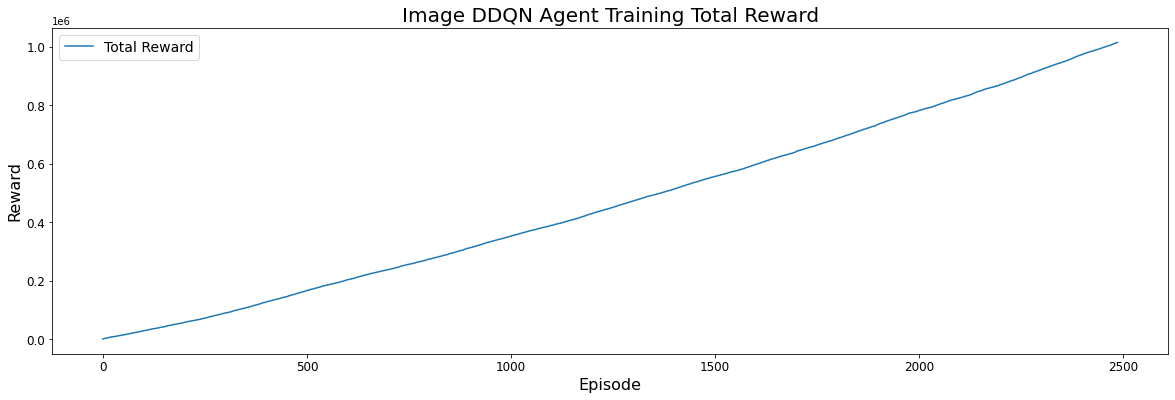

In [6]:
# Plot the training reward cumulative sum throughout the episodes (1 episode = 3 player lives)
plot_df(train_df,
        cols=['Total Reward'], 
        x_label='Episode', 
        y_label='Reward',
        title='Image DDQN Agent Training Total Reward')

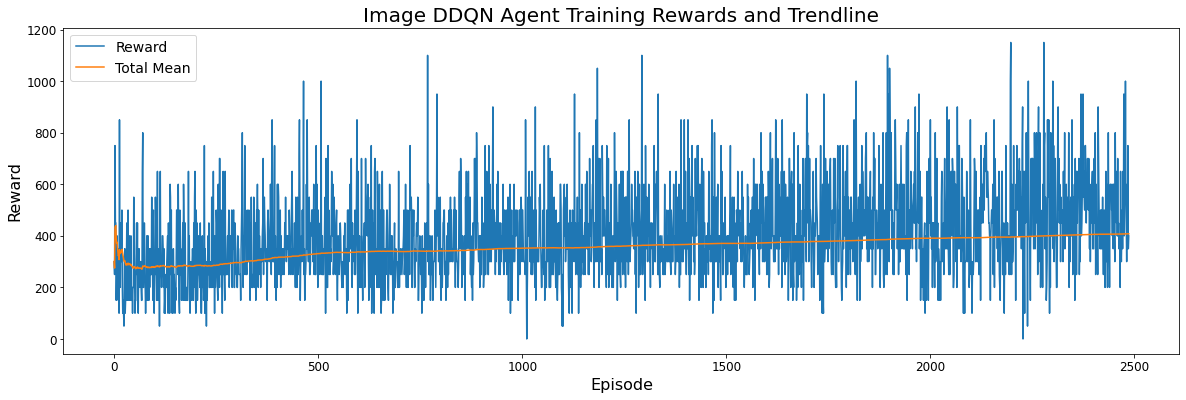

In [7]:
# Plot the training reward values throughout the episodes (1 episode = 3 player lives)
plot_df(train_df, 
        cols=['Reward', 'Total Mean'], 
        x_label='Episode', 
        y_label='Reward',
        title='Image DDQN Agent Training Rewards and Trendline')

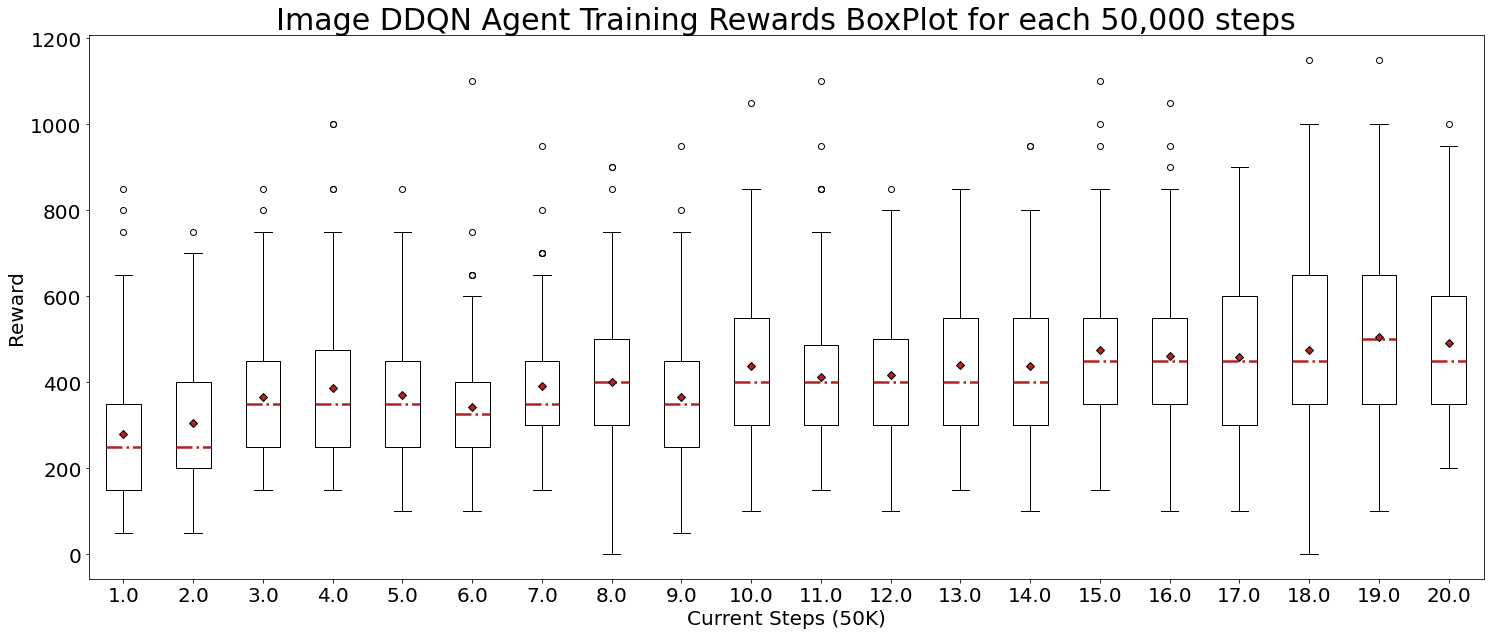

In [8]:
# Display a boxplot of the DDQN agent training data (agent rewards)
plot_boxplot_for_episodes(train_df, 
                          ['Reward'], 
                          ['DDQN-Image'], 
                          x_label='Current Steps (50K)', 
                          y_label='Reward', 
                          title='Image DDQN Agent Training Rewards BoxPlot for each 50,000 steps')

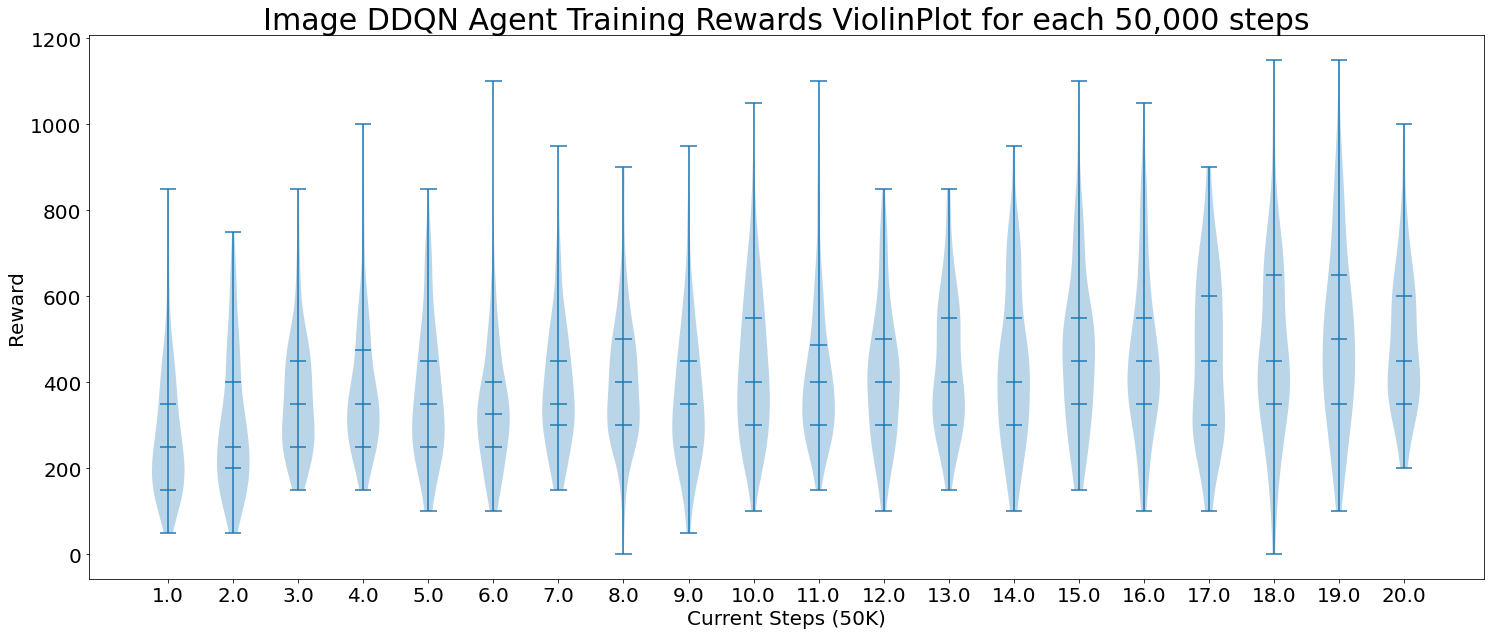

In [9]:
plot_violinplot_for_episodes(train_df, 
                             ['Reward'], 
                             ['DDQN-Image'], 
                             x_label='Current Steps (50K)', 
                             y_label='Reward', 
                             title='Image DDQN Agent Training Rewards ViolinPlot for each 50,000 steps')

In [40]:
# Save the obtaine DDQN training data to a CSV file
train_df.to_csv('image_ddqn_final.csv')

In [39]:
# Create a HDF5 file with the trained online model
# with all the details necessary to reconstitute it. 
ddqn_online = ddqn_agent.online
ddqn_online.save('image_ddqn_online_final.h5') 

# Create a HDF5 file with the trained target model
# with all the details necessary to reconstitute it. 
ddqn_target = ddqn_agent.target
ddqn_target.save('image_ddqn_target_final.h5')  

tf.keras.utils.plot_model(ddqn_online, to_file="architectures/dqnn_final.png")

NameError: name 'ddqn_agent' is not defined